In [1]:
import torch
#torch.set_default_dtype(torch.float64) # 设置默认张量数据类型为双精度浮点数
torch.manual_seed(123) # 设置随机数种子为33
%matplotlib widget 

In [6]:
from kan import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# 创建一个KAN模型：
# 输入维度为2，输出维度为1，隐藏层有5个神经元
# 使用三次样条（k=3），将输入空间划分为5个网格间隔（grid=5）
# 设置随机数种子为0
model_LF = KAN(width=[2,7,1], grid=10, k=7, seed=0, device=device)

In [3]:
# 定义数据集函数 f(x,y) = exp(sin(pi*x) + y^2)
#f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
f_L = lambda x: ((1.5 - x[:, [0]] + x[:, [0]] * x[:, [1]]) ** 2 + (2.25 - x[:, [0]] + x[:, [0]] * x[:, [1]] ** 2) ** 2 + (2.625 - x[:, [0]] + x[:, [0]] * x[:, [1]] ** 3) ** 2) * 0.5 + 10 * torch.Tensor(1,1).uniform_(0,1)
f_H = lambda x: (1.5 - x[:, [0]] + x[:, [0]] * x[:, [1]]) ** 2 + (2.25 - x[:, [0]] + x[:, [0]] * x[:, [1]] ** 2) ** 2 + (2.625 - x[:, [0]] + x[:, [0]] * x[:, [1]] ** 3) ** 2

# beale
# y_H = (1.5 - x1 + x1 * x2) ** 2 + (2.25 - x1 + x1 * x2 ** 2) ** 2 + (2.625 - x1 + x1 * x2 ** 3) ** 2
# y_L = 0.5 * y_H + 10 * np.random.uniform(0, 1)
# 使用 create_dataset 函数创建数据集
# 数据集包含两个自变量（n_var=2）
# 数据集会根据设备 device 进行处理
dataset_LF = create_dataset(f_L, n_var=2, device=device, train_num=200, test_num=200, ranges = [[-4.5,4.5],[-4.5,4.5]], normalize_input=True, normalize_label=True)

In [4]:
LF_train_sample = torch.cat((dataset_LF['train_input_true'],dataset_LF['train_label_true']),axis = 1)
LF_test_sample = torch.cat((dataset_LF['test_input_true'],dataset_LF['test_label_true']),axis = 1)
np.savetxt(f'D:/桌面/KAN_hmx/KAN/model_ckpt/beale_HF/beale_HF_samples/beale_LF_train_200.csv',LF_train_sample.cpu().numpy(),delimiter=',')



train loss: 1.25e-01 | test loss: 1.33e-01 | reg: 1.18e+01 : 100%|██| 20/20 [00:12<00:00,  1.63it/s]


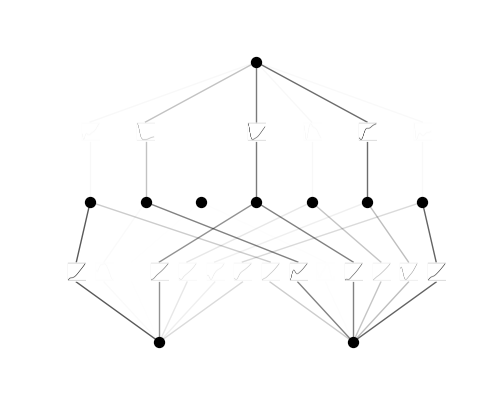

In [7]:
#model_LF.train(dataset_LF, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10., device=device, lr=0.1)
model_LF.train(dataset_LF, opt="LBFGS", steps=20, device=device, lr=0.01, lamb=0.01, lamb_entropy=2.)
model_LF.plot()

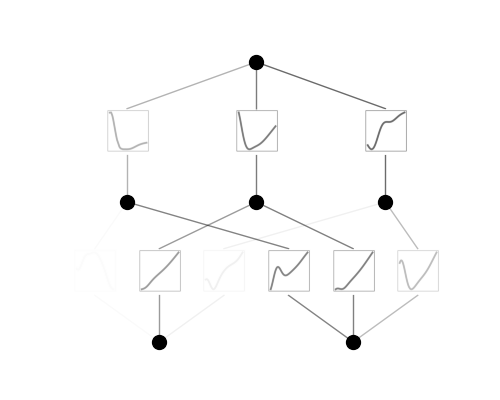

In [8]:
# 修剪KAN模型，并将修剪后的模型重新赋值给原来的模型变量
model_LF = model_LF.prune()
# 使用修剪后的模型对训练输入数据进行预测
model_LF(dataset_LF['train_input'])
# 使用 plot 方法绘制修剪后的KAN模型的输出结果
model_LF.plot()

train loss: 7.38e-03 | test loss: 3.19e-02 | reg: 5.29e+00 : 100%|██| 50/50 [00:19<00:00,  2.61it/s]


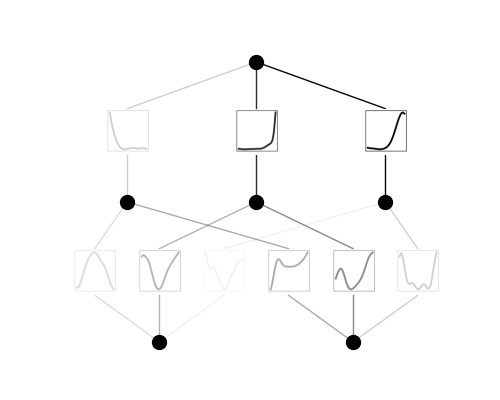

In [9]:
# 继续对模型进行训练
# 使用 LBFGS 优化器
# 进行 50 步训练
# 在给定的设备上进行训练
model_LF.train(dataset_LF, opt="LBFGS", steps=50,device=device, lr=0.1)
model_LF.plot()

In [10]:
# 设置 mode 变量为 "auto" 或 "manual"，以确定激活函数的设置方式
mode = "auto"  # 或者 mode = "manual"
# 如果 mode 是 "manual"，则手动设置激活函数为符号函数
if mode == "manual":
    # 手动模式下，逐个指定隐藏层和输入层的激活函数
    # 第一个参数表示层的索引，第二个和第三个参数表示神经元的索引
    # 第四个参数为要设置的激活函数，例如 'sin', 'x^2', 'exp' 等
    model_LF.fix_symbolic(0, 0, 0, 'sin') # 设置第一个隐藏层的第一个神经元的激活函数为正弦函数
    model_LF.fix_symbolic(0, 1, 0, 'x^2') # 设置第一个隐藏层的第二个神经元的激活函数为平方函数
    model_LF.fix_symbolic(1, 0, 0, 'exp') # 设置输出层的第一个神经元的激活函数为指数函数
# 如果 mode 是 "auto"，则自动设置激活函数为符号函数
elif mode == "auto":
    # 自动模式下，根据提供的激活函数库自动选择合适的符号函数作为激活函数
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model_LF.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9912511706352234
fixing (0,0,1) with sin, r2=0.9758234620094299
fixing (0,0,2) with abs, r2=0.9492457509040833
fixing (0,1,0) with tanh, r2=0.711974561214447
fixing (0,1,1) with abs, r2=0.8849833011627197
fixing (0,1,2) with x^4, r2=0.9118667840957642
fixing (1,0,0) with x^4, r2=0.9705886840820312
fixing (1,1,0) with x^4, r2=0.8733959197998047
fixing (1,2,0) with x^2, r2=0.9703454375267029


train loss: 2.89e-02 | test loss: 4.12e-02 | reg: 5.19e+00 : 100%|█| 100/100 [00:16<00:00,  6.17it/s


56.7*(-(0.52 - x_2)**4 - 0.01*Abs(10.0*x_1 - 5.0) + 0.03)**2 + 0.09*(0.63*sin(4.77*x_1 + 8.61) - 0.78*tanh(10.0*x_2 - 0.2) + 1)**4 - 0.02


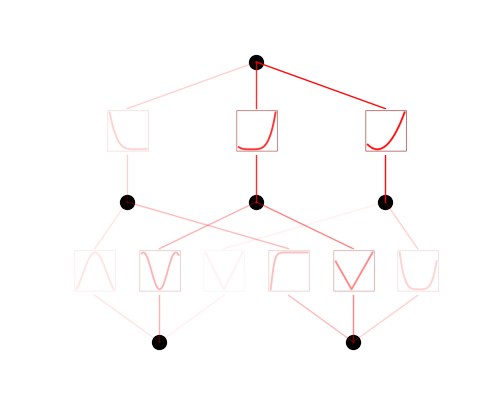

In [11]:
model_LF.train(dataset_LF, opt="LBFGS", steps=100, device=device,lr=0.001) # 继续对模型进行训练
print(model_LF.symbolic_formula()[0][0]) # 获取模型的符号化公式
model_LF.plot()

In [12]:
test_output = model_LF(dataset_LF['test_input'])*(dataset_LF['max_label']-dataset_LF['min_label'])+dataset_LF['min_label']
true_output=f_L(dataset_LF['test_input_true'].cpu().detach())

In [13]:
#model_LF.save_ckpt('beale_LF_model')
#torch.save(model_LF,'./model_ckpt/beale_LF_model.pth')

import dill #用于函数打包存储
#储存模型
with open('./model_ckpt/beale_LF_model.pkl', 'wb') as f:
   	dill.dump(model_LF, f)
# #读取模型
# with open(file_name, 'rb') as f:
# data_pack = pickle.load(f)


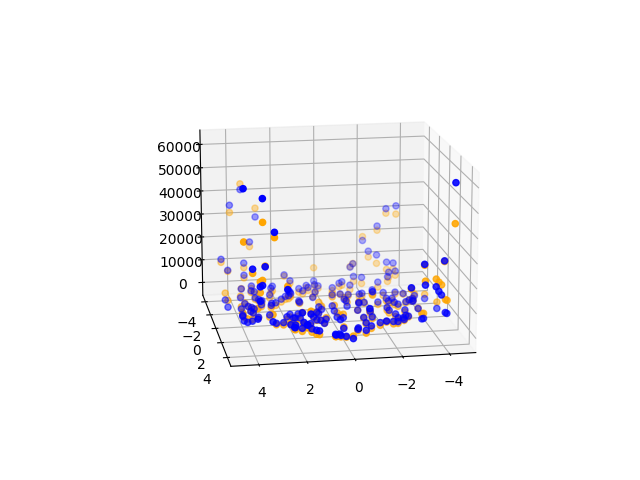

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(dataset_LF['test_input_true'].cpu().detach().numpy()[:, 0], dataset_LF['test_input_true'].cpu().detach().numpy()[:, 1], test_output.cpu().detach().numpy(), color='orange')
ax.scatter(dataset_LF['test_input_true'].cpu().detach().numpy()[:, 0], dataset_LF['test_input_true'].cpu().detach().numpy()[:, 1], true_output, color='blue')
ax.view_init(elev=15,    # 仰角
             azim=80   # 方位角
            )
plt.show()

In [15]:
dataset_HF = create_dataset(f_H, n_var=2, device=device, train_num=3, test_num=100, ranges = [[-4.5,4.5],[-4.5,4.5]], normalize_input=True, normalize_label=True)
def normalize(data, max, min):
            return (data-min)/(max-min)
dataset_HF['max_input'] = dataset_LF['max_input']
dataset_HF['min_input'] = dataset_LF['min_input']

dataset_HF['max_label'] = dataset_LF['max_label']
dataset_HF['min_label'] = dataset_LF['min_label']

dataset_HF['train_input'] = normalize(dataset_HF['train_input_true'].to('cpu'), dataset_HF['max_input'], dataset_HF['min_input']).to(device)
dataset_HF['test_input'] = normalize(dataset_HF['test_input_true'].to('cpu'), dataset_HF['max_input'], dataset_HF['min_input']).to(device)

dataset_HF['train_label'] = normalize(dataset_HF['train_label_true'].to('cpu'), dataset_HF['max_label'], dataset_HF['min_label']).to(device)
dataset_HF['test_label'] = normalize(dataset_HF['test_label_true'].to('cpu'), dataset_HF['max_label'], dataset_HF['min_label']).to(device)

In [22]:
HF_train_sample = torch.cat((dataset_HF['train_input_true'],dataset_HF['train_label_true']),axis = 1)
HF_test_sample = torch.cat((dataset_HF['test_input_true'],dataset_HF['test_label_true']),axis = 1)
np.savetxt(f'D:/桌面/KAN_hmx/KAN/model_ckpt/beale_HF/beale_HF_samples/beale_HF_test_100.csv',HF_test_sample.cpu().numpy(),delimiter=',')

In [26]:
import dill
with open('./model_ckpt/beale_LF_model.pkl', 'rb') as f:
    model_LF_base = dill.load(f)

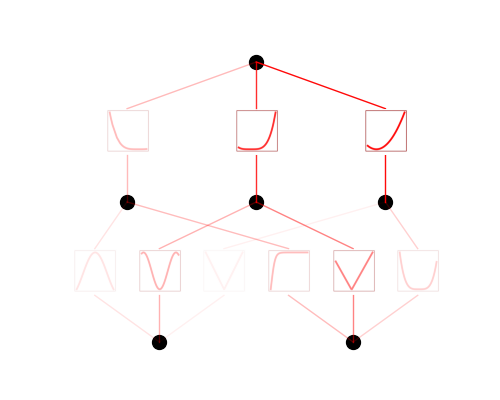

In [27]:
import dill
with open('./model_ckpt/beale_LF_model.pkl', 'rb') as f:
    model_LF = dill.load(f)
model_HF = KAN(width=model_LF.width, grid=100, k=7, seed=0, device=device)
model_HF.initialize_from_another_model(model_LF, dataset_HF['train_input'])
model_HF(dataset_LF['train_input'])
model_HF.plot()

In [24]:
print(model_HF.symbolic_formula()[0][0]) # 获取模型的符号化公式
print(model_LF.symbolic_formula()[0][0]) # 获取模型的符号化公式

56.7*(-(0.52 - x_2)**4 - 0.01*Abs(10.0*x_1 - 5.0) + 0.03)**2 + 0.09*(0.63*sin(4.77*x_1 + 8.61) - 0.78*tanh(10.0*x_2 - 0.2) + 1)**4 - 0.02
56.7*(-(0.52 - x_2)**4 - 0.01*Abs(10.0*x_1 - 5.0) + 0.03)**2 + 0.09*(0.63*sin(4.77*x_1 + 8.61) - 0.78*tanh(10.0*x_2 - 0.2) + 1)**4 - 0.02


train loss: 4.47e-07 | test loss: 1.35e-01 | reg: 5.88e+00 : 100%|█| 100/100 [00:32<00:00,  3.11it/s
train loss: 5.35e-04 | test loss: 1.01e-01 | reg: 6.04e+00 : 100%|█| 100/100 [00:40<00:00,  2.48it/s


93.8*(-(0.52 - x_2)**4 - 0.e-2*Abs(10.0*x_1 - 5.0) + 0.02)**2 + 0.15*(0.56*sin(4.77*x_1 + 8.61) - 0.68*tanh(10.0*x_2 - 0.2) + 1)**4 - 0.03


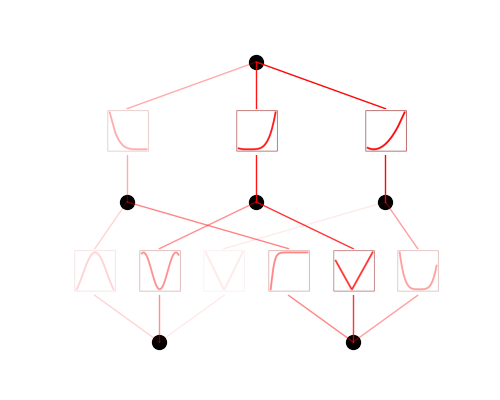

In [28]:
from audtorch.metrics.functional import pearsonr
# loss_fn = lambda x,y: torch.mean((x-y)**2)+0.5*torch.abs(pearsonr(model_HF(dataset_HF['train_input']).view(1,-1).to(device),model_LF(dataset_HF['train_input']).view(1,-1).to(device))[:,0][0]-pearsonr(model_HF(dataset_LF['train_input']).view(1,-1).to(device),dataset_LF['train_label'].view(1,-1).to(device))[:,0][0])
# model_HF.train(dataset_HF, opt="LBFGS", steps=500, device=device,lr=0.1,loss_fn=loss_fn)
a = torch.cat((dataset_HF['train_label'].view(1,-1).to(device),model_HF(dataset_LF['train_input']).view(1,-1).to(device)),axis=1).to(device)
b = torch.cat((model_LF(dataset_HF['train_input']).view(1,-1).to(device),dataset_LF['train_label'].view(1,-1).to(device)),axis=1).to(device)
loss_fn1 = lambda x, y: torch.mean((x - y) ** 2) + 0.5 * torch.abs(
            pearsonr(dataset_HF['train_label'].view(1, -1).to(device),
                     model_LF_base(dataset_HF['train_input']).view(1, -1).to(device))[:, 0][0] -
            pearsonr(model_HF(dataset_LF['train_input']).view(1, -1).to(device),
                     model_LF_base(dataset_LF['train_input']).view(1, -1).to(device))[:, 0][0])

loss_fn2 = lambda x,y: torch.mean((x-y)**2)+0.0*torch.abs(pearsonr(model_HF(dataset_HF['train_input']).view(1,-1).to(device),model_LF(dataset_HF['train_input']).view(1,-1).to(device))[:,0][0]-pearsonr(model_HF(dataset_LF['train_input']).view(1,-1).to(device),dataset_LF['train_label'].view(1,-1).to(device))[:,0][0])

model_HF.train(dataset_HF, opt="LBFGS", steps=100, device=device,lr=0.1,loss_fn=loss_fn2)
#model_HF.train(dataset_HF, opt="Adam", steps=500, device=device,lr=0.001,loss_fn=loss_fn1)
model_HF.train(dataset_HF, opt="LBFGS", steps=100, device=device,lr=0.1,loss_fn=loss_fn1)
print(model_HF.symbolic_formula()[0][0]) # 获取模型的符号化公式
model_HF.plot()

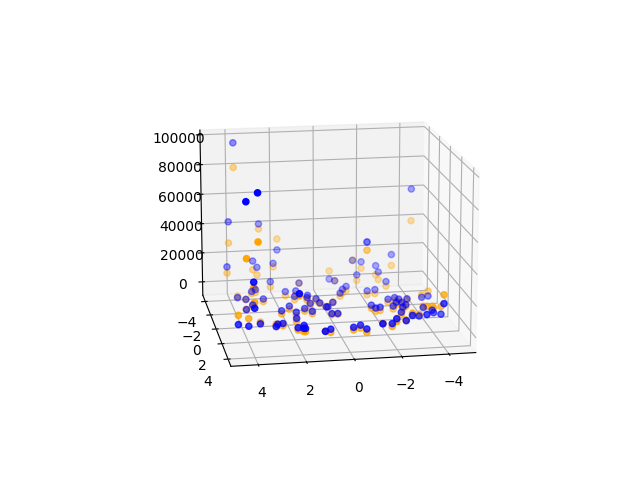

In [29]:

test_output = model_HF(dataset_HF['test_input'])*(dataset_HF['max_label']-dataset_HF['min_label'])+dataset_HF['min_label']
true_output=f_H(dataset_HF['test_input_true'].cpu().detach())

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(dataset_HF['test_input_true'].cpu().detach().numpy()[:, 0], dataset_HF['test_input_true'].cpu().detach().numpy()[:, 1], test_output.cpu().detach().numpy(), color='orange')
ax.scatter(dataset_HF['test_input_true'].cpu().detach().numpy()[:, 0], dataset_HF['test_input_true'].cpu().detach().numpy()[:, 1], true_output, color='blue')
ax.view_init(elev=15,    # 仰角
             azim=80   # 方位角
            )
plt.show()

In [30]:
from math import sqrt
def NRMSE(y, ytest, r_num):
    nrmse = []
    for i in range(r_num):
        sum_1 = np.sum(np.power(y[:,i] - ytest[:,i], 2))
        sum_2 = np.sum(np.power(ytest[:,i], 2))
        nrmse.append(sqrt(sum_1 / sum_2))
    #print('nrmse='+str(nrmse))
    NRMSE = np.mean(nrmse)
    return NRMSE

In [31]:
nrmse = NRMSE(test_output.cpu().detach().numpy(),true_output.numpy(),1)
nrmse

0.30879571800129063